In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Load the prepared data
We will load the prepared insurance dataset.

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Insurance fraud detection/dataset/insurance_data_prepared.csv'
df = pd.read_csv(file_path)

df.head()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,...,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen
0,328,48,1000,1406.91,0,466132,53300,0,5,1,...,False,False,False,False,False,False,True,False,False,False
1,228,42,2000,1197.22,5000000,468176,0,0,8,1,...,False,False,False,False,True,False,False,False,False,False
2,134,29,2000,1413.14,5000000,430632,35100,0,7,3,...,True,False,False,False,False,False,False,False,False,False
3,256,41,2000,1415.74,6000000,608117,48900,-62400,5,1,...,False,False,False,False,False,False,False,False,False,False
4,228,44,1000,1583.91,6000000,610706,66000,-46000,20,1,...,False,False,False,False,False,False,False,False,False,False


# Split the Data into Training and Testing Sets

In [ ]:
from sklearn.model_selection import train_test_split

y = df['fraud_reported']
X = df.drop('fraud_reported',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Model

Random Forest is an ensemble machine learning algorithm that operates by building multiple decision trees during training and outputting the average of the predictions from individual trees for regression tasks, or the majority vote for classification tasks.

Let's import all the required libraries for training the model and plotting our graphs.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

We will use Grid Search for hyperparameter tuning. GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter.
Let's define our hyperparameter bounds and optimization function.

In [ ]:
def search_params(param_grid):
  rf_model = RandomForestClassifier(random_state=42)
  grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
  grid_search.fit(X_train, y_train)
  return grid_search.best_params_

param_grid = {
    'n_estimators': [20, 25, 30],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 5, 7],
    'max_leaf_nodes': [3, 6, 9],
    'min_samples_split': [2, 4, 6],
}
params = search_params(param_grid)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


Now we build train the model with hyperparameters derived from previous step. Finally we plot its learning rate.

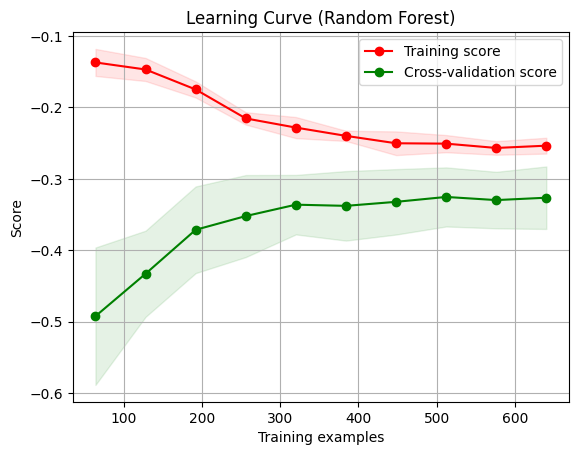

Test Accuracy: 83.00%


In [ ]:
def rf_train(X_train, y_train, params):
  rf_model = RandomForestClassifier(random_state=42, **params)
  rf_model.fit(X_train, y_train)
  return rf_model

def show_learning_curve(X_train, y_train, params):
  rf_model = RandomForestClassifier(random_state=42, **params)
  train_sizes, train_scores, test_scores = learning_curve(
      rf_model, X_train, y_train, cv=5, scoring='neg_log_loss',
      train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
  )

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.figure()
  plt.title("Learning Curve (Random Forest)")
  plt.xlabel("Training examples")
  plt.ylabel("Score")

  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")

  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

  plt.legend(loc="best")
  plt.grid()
  plt.savefig('/content/drive/MyDrive/Insurance fraud detection/results/random_forest_learning_curve.png')
  plt.show()

rf_model = rf_train(X_train, y_train, params)
y_pred = rf_model.predict(X_test)
show_learning_curve(X_train,y_train, params)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

# Results

We plot confusion matrix, ROC curve, feature importance map and classification report for our model.

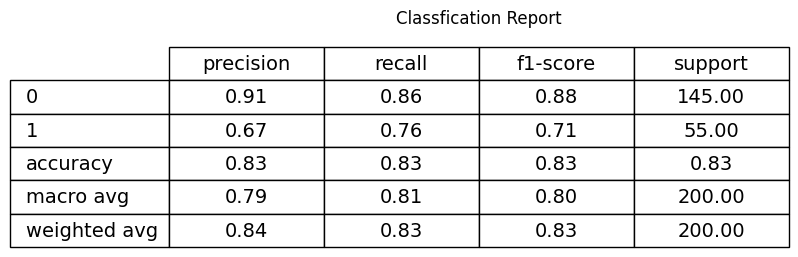

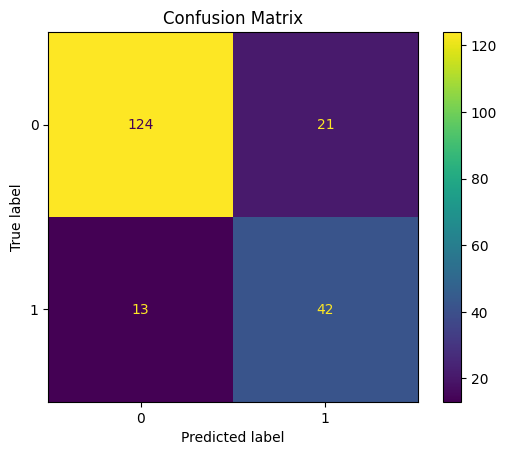

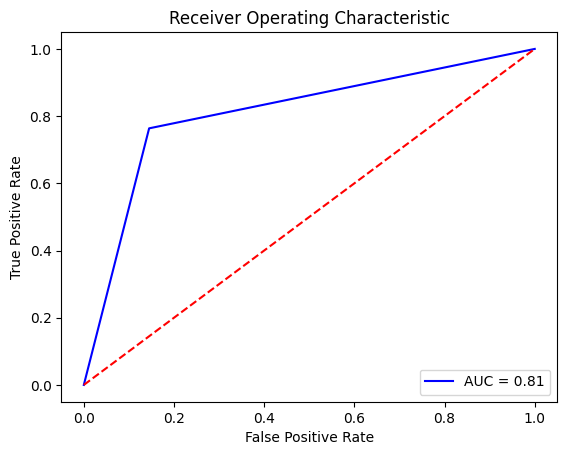

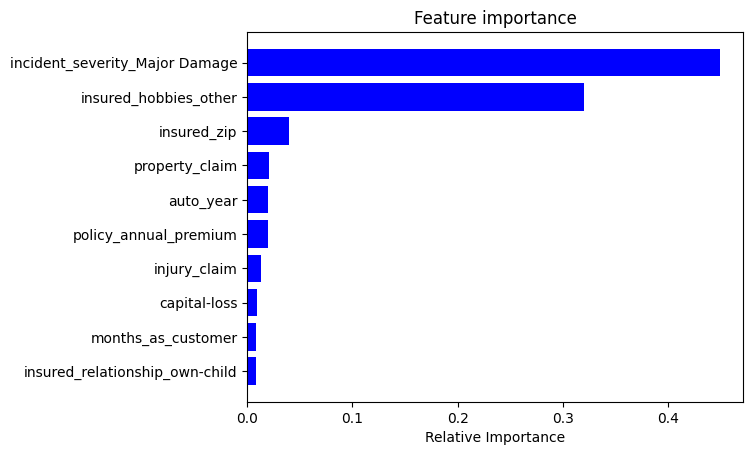

In [ ]:
def plot_conf_matrix(y_test, y_pred):
  disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
  plt.title('Confusion Matrix')
  plt.savefig('/content/drive/MyDrive/Insurance fraud detection/results/random_forest_conf_matrix.png')
  plt.show()

def plot_roc(y_test,y_pred):
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.gcf().savefig('/content/drive/MyDrive/Insurance fraud detection/results/random_forest_roc.png')
  plt.show()

def plot_feature_imp(rf_model):
  features = X.columns
  importances = rf_model.feature_importances_
  indices = np.argsort(-importances)[:10][::-1]
  plt.title('Feature importance')
  plt.barh(range(len(indices)), importances[indices], color='b', align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.savefig('/content/drive/MyDrive/Insurance fraud detection/results/random_forest_feature_imp.png',bbox_inches="tight")
  plt.show()

def gen_classification_report(y_test, y_pred):
  class_report = classification_report(y_test, y_pred, output_dict=True)
  class_report_df = pd.DataFrame(class_report).transpose()
  class_report_df.update(class_report_df.applymap('{:,.2f}'.format))
  fig = plt.figure(figsize = (8, .2))
  ax = fig.add_subplot(111)
  tb = ax.table(cellText = class_report_df.values, rowLabels = class_report_df.index, colLabels = class_report_df.columns, cellLoc='center')
  tb.scale(1, 2)
  tb.auto_set_font_size(False)
  tb.set_fontsize(14)
  ax.set_title('Classfication Report')
  ax.axis('off')
  plt.savefig('/content/drive/MyDrive/Insurance fraud detection/results/random_forest_classification_report.png',bbox_inches="tight")
  plt.show()

gen_classification_report(y_test,y_pred)
plot_conf_matrix(y_test,y_pred)
plot_roc(y_test,y_pred)
plot_feature_imp(rf_model)
plt.show()

# Save the model

Finally we save the model, ready for furthur inference.

In [ ]:
import pickle

model_path = '/content/drive/MyDrive/Insurance fraud detection/models/random_forest_model.pkl'
pickle.dump(rf_model, open(model_path, "wb"))

print(f'Model saved to {model_path}')

Model saved to /content/drive/MyDrive/Insurance fraud detection/models/random_forest_model.pkl
